# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/CNN.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/Bongard Testing.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
from os import path
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import accuracy_score
import time
import natsort
from PIL import Image
start_time = time.time()

# Functions:

#### 1) Function to plot bongard images

In [5]:
def load_and_resize_images(folder_path, target_size):
    image_paths = glob.glob(os.path.join(folder_path, '*.png'))
    image_paths = natsort.natsorted(image_paths)
    images = []
    for img_path in image_paths:
        with Image.open(img_path) as img:
            img = img.resize(target_size)
            if img.mode == 'RGBA':
                img = img.convert('L')
            img_arr = np.array(img)
            if len(img_arr.shape) == 2:
                img_arr = img_arr[..., np.newaxis]
            images.append(img_arr)
    return np.array(images)

def plot_image_from_array(images_array, image_index, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(images_array[image_index, :, :, 0], cmap='gray', aspect='auto')
    plt.title(f"Image {image_index + 1}")
    plt.axis('off')
    plt.show()

folder_B_path = '/content/Bongard Testing/BP'
target_size = (330, 516)
images_array = load_and_resize_images(folder_B_path, target_size)

#### 2) Function to preprocess images

In [6]:
# Preprocessing:
def load_imgs(list_of_img_paths):
    alpaca_lst = []
    for imgs in list_of_img_paths:
        img=tf.keras.utils.load_img(
                            imgs,
                            color_mode = "grayscale",
                            target_size=None,
                            interpolation="nearest",
                            keep_aspect_ratio=False)

        input_arr = tf.keras.utils.img_to_array(img)

        inpt_img_arr = input_arr / 255.0
        alpaca_lst.append(inpt_img_arr)
    imgs_arr =np.array(alpaca_lst)
    return imgs_arr

#### 3) Function to plot any image with their labels

In [7]:
import matplotlib.pyplot as plt

def plot_images_with_labels(images, labels):
    plt.figure(figsize=(12, 8))

    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns for a 2x5 grid of subplots
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### 4) functions to create masked labels

In [8]:
# Generate masked labels for heads except selected head
def create_masked_labels(selected_head_name, excluded_head_names, labels):
    masked_labels = {}
    masked_labels[selected_head_name] = labels
    for head_name in excluded_head_names:
        masked_labels[head_name] = np.full_like(labels, -1)
    return masked_labels
def masked_label(selected_head_name,Ci_y_train):
    # Define the list of output head layer names
    output_names = ['center_vs_notincenter','circle_vs_notcircle','Closed_vs_Open_figure',
                'Colinear_vs_Noncolinear','Concave_vs_Convex','Four_vs_notfour_side','Triangle_vs_notTriangle',
                'Clockwise_vs_Anticlock_wise','Left_vs_Right','Parallel_vs_perpendicular','Filled_vs_Unfilled',
                'Complete_vs_Incomplete','Intersect_vs_NonIntersect','M_cluster_vs_N_clusters','Above_vs_Below',
                'Same_vs_Not_Same','Size_big_vs_Small','Symmetery_vs_Non_symmetery','Horizontal_vs_Vertical',
                'Empty_vs_Non_Empty']

    # Exclude the selected head from generating masked labels
    excluded_head_names = [name for name in output_names if name != selected_head_name]

    # Generate masked labels for all excluded heads
    Ci_masked_labels = create_masked_labels(selected_head_name, excluded_head_names, Ci_y_train)
    return Ci_masked_labels

#### 5) Function to preprocess and split the data into training and testing

In [9]:
def data_load_split(Classifier_path,folder_A,folder_B):
    os.getcwd()
    dataset_path = os.getcwd()
    a = os.path.join('/content/CNN',Classifier_path)
    A = os.path.join(dataset_path, a)
    A_A = os.path.join(A, folder_A)
    A_B = os.path.join(A, folder_B)
    A_A = glob.glob(A_A +"/*.png")
    A_B = glob.glob(A_B +"/*.png")
    A_A_arr =load_imgs(A_A)
    A_B_arr =load_imgs(A_B)


    # Generate labels corresponding to above concept classes.
    A_A_labels =  np.zeros([len(A_A_arr), 1], dtype = int)  #labeled as 0
    A_B_labels =  np.ones([len(A_B_arr), 1], dtype = int) #labeled as 1

    Ci_X = np.concatenate((A_A_arr, A_B_arr), axis=0)
    Ci_y = np.concatenate((A_A_labels , A_B_labels), axis=0)

    # Split the data into training and testing sets
    Ci_X_train, Ci_X_test, Ci_y_train, Ci_y_test = train_test_split(Ci_X, Ci_y,
                                                                    test_size=0.2, random_state=42, shuffle=True)

    return Ci_X_train,Ci_X_test,Ci_y_train,Ci_y_test

#### Automate the code to load every classifier images and split.

In [10]:
# Path to the main folder
main_folder_path = "/content/CNN"

# Get the names of first-level subfolders in "A"
subfolder_names = [name for name in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, name))]
subfolder_names = sorted(subfolder_names)
start_time = time.time()
# Iterate through the first-level subfolders and call data_load_split
for i, subfolder_name in enumerate(subfolder_names):
    subfolder_path = os.path.join(main_folder_path, subfolder_name)
    subsubfolder_names = [name for name in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, name))]

    if len(subsubfolder_names) == 2:
        print(f'classifier C{i}:', subfolder_name)
#         print(subsubfolder_names[0],subsubfolder_names[1])
        exec(f'C{i}_X_train, C{i}_X_test, C{i}_y_train, C{i}_y_test = data_load_split(subfolder_name,subsubfolder_names[0],subsubfolder_names[1])')
        print("Shape:")

        print(locals()[f'C{i}_X_train'].shape, locals()[f'C{i}_y_train'].shape,locals()[f'C{i}_X_test'].shape,
        locals()[f'C{i}_y_test'].shape)
        print('\n')
end_time = time.time()
Preprocess_Time = end_time - start_time
print("Time taken for Preprocess data:", Preprocess_Time, "seconds")

classifier C0: B) center  vs not incenter
Shape:
(3680, 100, 100, 1) (3680, 1) (920, 100, 100, 1) (920, 1)


classifier C1: C) Circle vs not circle
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C2: D) Closed figure vs Open figure
Shape:
(1232, 100, 100, 1) (1232, 1) (308, 100, 100, 1) (308, 1)


classifier C3: E) Co-linear vs Non-colinear
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C4: F) Concave vs Convex
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C5: G) Four sides vs not four side
Shape:
(5600, 100, 100, 1) (5600, 1) (1400, 100, 100, 1) (1400, 1)


classifier C6: H) Triangle vs not Triangle
Shape:
(5584, 100, 100, 1) (5584, 1) (1396, 100, 100, 1) (1396, 1)


classifier C7: I) Clockwise vs Anticlock wise
Shape:
(2400, 100, 100, 1) (2400, 1) (600, 100, 100, 1) (600, 1)


classifier C8: J) Left vs Right
Shape:
(2000, 100, 100, 1) (2000, 1) (500, 100, 100, 1) (500, 1)


classifier C9: K) 

# Multi-Head CNN

In [11]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Input Shape
input_shape = (100, 100, 1)
input_layer = Input(shape=input_shape)

# CNN common model:
CNN_L1 = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(input_layer)
CNN_L2 = BatchNormalization()(CNN_L1)
CNN_L3 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L2)

CNN_L4 = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L3)
CNN_L5 = BatchNormalization()(CNN_L4)
CNN_L6 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L5)

CNN_L7 = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L6)
CNN_L8 = BatchNormalization()(CNN_L7)
CNN_L9 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L8)

CNN_L10 = Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L9)
CNN_L11 = BatchNormalization()(CNN_L10)
CNN_L12 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L11)

CNN_L13 = Flatten()(CNN_L12)

# Add more layers
Common_Layer = Dense(128, activation='relu')(CNN_L13)
Common_Layer = Dense(10, activation='relu')(Common_Layer)

# Individual Head: Center vs not incenter
center_vs_notincenter_head = Dense(1, activation='sigmoid', name='center_vs_notincenter')(Common_Layer)

# Individual Head: Circle vs not circle
circle_vs_notcircle_head = Dense(1, activation='sigmoid', name='circle_vs_notcircle')(Common_Layer)

# Individual Head: Closed_vs_Open_figure
Closed_vs_Open_figure = Dense(1, activation='sigmoid', name='Closed_vs_Open_figure')(Common_Layer)

# Individual Head: Co-linear_vs_Non-colinear
Colinear_vs_Noncolinear = Dense(1, activation='sigmoid', name='Colinear_vs_Noncolinear')(Common_Layer)

# Individual Head: Concave_vs_Convex
Concave_vs_Convex = Dense(1, activation='sigmoid', name='Concave_vs_Convex')(Common_Layer)


Four_vs_notfour_side =Dense(1, activation='sigmoid', name='Four_vs_notfour_side')(Common_Layer)


Triangle_vs_notTriangle =Dense(1, activation='sigmoid', name='Triangle_vs_notTriangle')(Common_Layer)


Clockwise_vs_Anticlock_wise =  Dense(1, activation='sigmoid', name='Clockwise_vs_Anticlock_wise')(Common_Layer)


Left_vs_Right =  Dense(1, activation='sigmoid', name='Left_vs_Right')(Common_Layer)


Parallel_vs_perpendicular =  Dense(1, activation='sigmoid', name='Parallel_vs_perpendicular')(Common_Layer)


Filled_vs_Unfilled =  Dense(1, activation='sigmoid', name='Filled_vs_Unfilled')(Common_Layer)


Complete_vs_Incomplete =  Dense(1, activation='sigmoid', name='Complete_vs_Incomplete')(Common_Layer)


Intersect_vs_NonIntersect =  Dense(1, activation='sigmoid', name='Intersect_vs_NonIntersect')(Common_Layer)


M_cluster_vs_N_clusters =  Dense(1, activation='sigmoid', name='M_cluster_vs_N_clusters')(Common_Layer)


Above_vs_Below =  Dense(1, activation='sigmoid', name='Above_vs_Below')(Common_Layer)


Same_vs_Not_Same =  Dense(1, activation='sigmoid', name='Same_vs_Not_Same')(Common_Layer)

Size_big_vs_Small =  Dense(1, activation='sigmoid', name='Size_big_vs_Small')(Common_Layer)

Symmetery_vs_Non_symmetery = Dense(1, activation='sigmoid', name='Symmetery_vs_Non_symmetery')(Common_Layer)

Horizontal_vs_Vertical = Dense(1, activation='sigmoid', name='Horizontal_vs_Vertical')(Common_Layer)

Empty_vs_Non_Empty = Dense(1, activation='sigmoid', name='Empty_vs_Non_Empty')(Common_Layer)


# Create the model
model = Model(inputs=input_layer, outputs=[
                                           center_vs_notincenter_head,
                                           circle_vs_notcircle_head,
                                           Closed_vs_Open_figure,
                                           Colinear_vs_Noncolinear,
                                           Concave_vs_Convex,
                                           Four_vs_notfour_side,
                                           Triangle_vs_notTriangle,
                                           Clockwise_vs_Anticlock_wise,
                                           Left_vs_Right,
                                           Parallel_vs_perpendicular,
                                           Filled_vs_Unfilled,
                                           Complete_vs_Incomplete,
                                           Intersect_vs_NonIntersect,
                                           M_cluster_vs_N_clusters,
                                           Above_vs_Below,
                                           Same_vs_Not_Same,
                                           Size_big_vs_Small,
                                            Symmetery_vs_Non_symmetery,
                                            Horizontal_vs_Vertical,
                                            Empty_vs_Non_Empty
                                          ])


def masked_binary_crossentropy(y_true, y_pred):
  mask = tf.not_equal(y_true, -1)
  masked_true = tf.boolean_mask(y_true, mask)
  masked_pred = tf.boolean_mask(y_pred, mask)

    # Check if there are non-empty masked values
  if tf.reduce_sum(tf.cast(mask, tf.float32)) > 0:
      loss = tf.keras.losses.binary_crossentropy(masked_true, masked_pred)
  else:
      loss = tf.constant(0.0)  # If all values are masked, set loss to 0

  return loss


# Compile the model with appropriate loss functions for each head
model.compile(optimizer='adam',
              loss=masked_binary_crossentropy,
              metrics='accuracy')

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 98, 98, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 98, 98, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

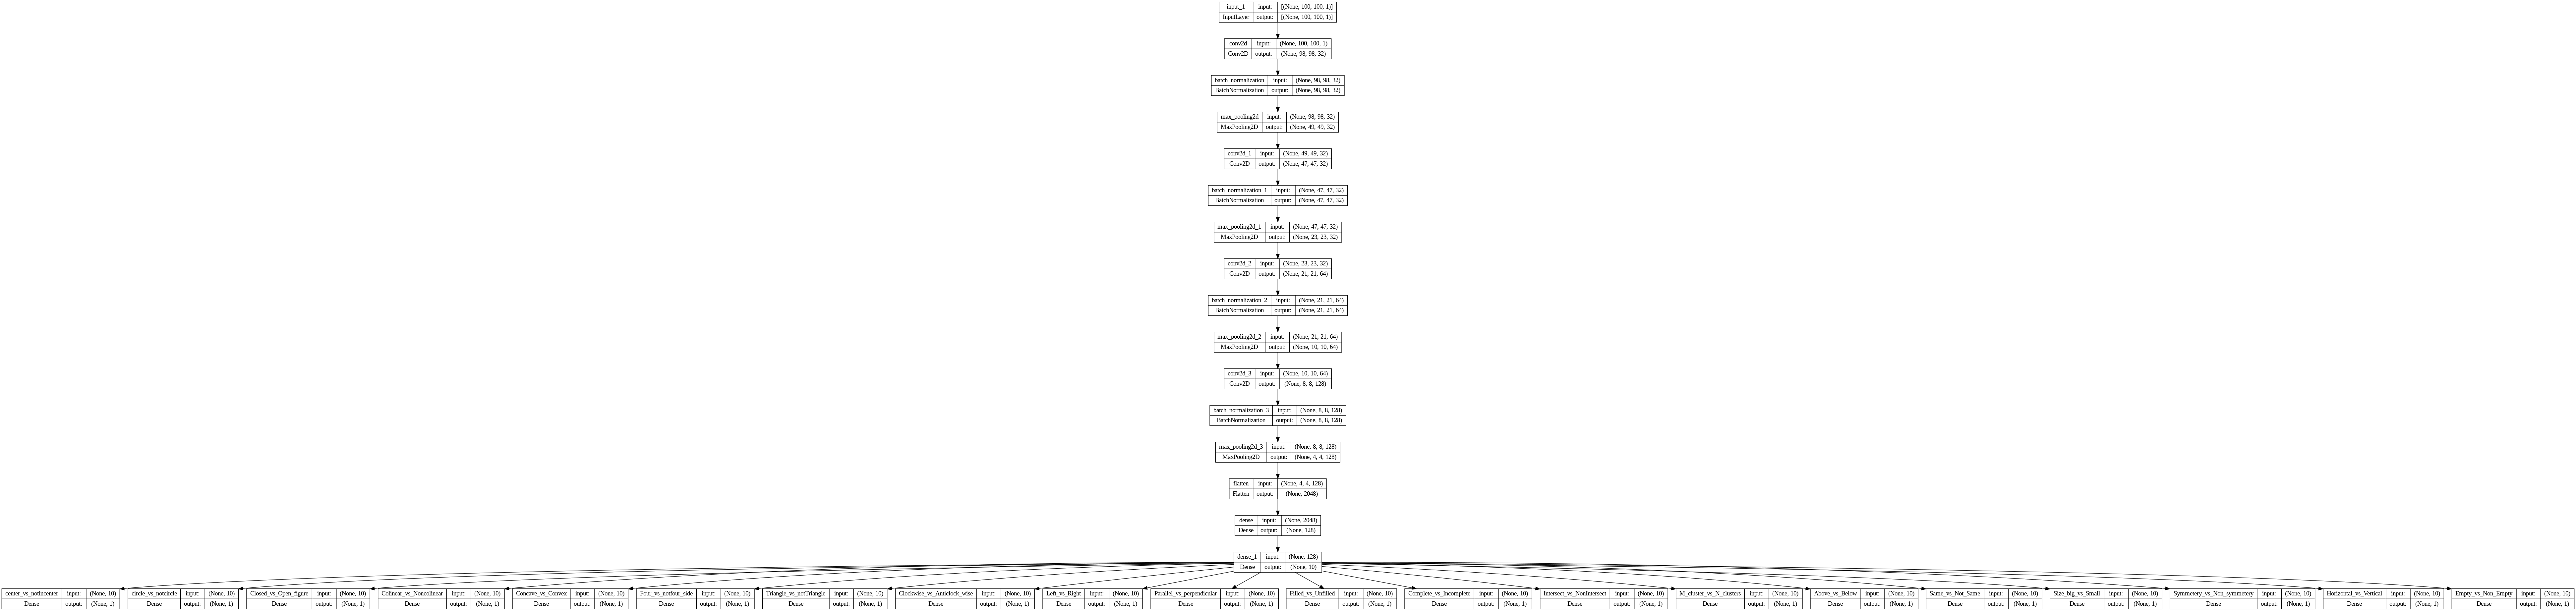

In [13]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [14]:
# To check the total number of images in Train_dict:
total_images = 0

# Train_dict containing subarrays.
Train_dict = {
    "Train": [C0_X_train, C1_X_train,C2_X_train,C3_X_train, C4_X_train,C5_X_train,C6_X_train, C7_X_train,C8_X_train,
              C9_X_train,C10_X_train,C11_X_train,C12_X_train, C13_X_train,C14_X_train,C15_X_train,C16_X_train,C17_X_train,
              C18_X_train,C19_X_train]
}

for subarray in Train_dict["Train"]:
    total_images += subarray.shape[0]
print("Total images in Train_dict: ",total_images)


Total images in Train_dict:  49054


In [15]:


Label_dict = {

    "center_vs_notincenter": np.full((total_images,),-1),
    "circle_vs_notcircle": np.full((total_images,),-1),
    "Closed_vs_Open_figure": np.full((total_images,),-1),
    "Colinear_vs_Noncolinear": np.full((total_images,),-1),
    "Concave_vs_Convex": np.full((total_images,),-1),
    "Four_vs_notfour_side": np.full((total_images,),-1),
    "Triangle_vs_notTriangle": np.full((total_images,),-1),
    "Clockwise_vs_Anticlock_wise": np.full((total_images,),-1),
    "Left_vs_Right": np.full((total_images,),-1),
    "Parallel_vs_perpendicular": np.full((total_images,),-1),
    "Filled_vs_Unfilled": np.full((total_images,),-1),
    "Complete_vs_Incomplete": np.full((total_images,),-1),
    "Intersect_vs_NonIntersect": np.full((total_images,),-1),
    "M_cluster_vs_N_clusters": np.full((total_images,),-1),
    "Above_vs_Below": np.full((total_images,),-1),
    "Same_vs_Not_Same": np.full((total_images,),-1),
    "Size_big_vs_Small": np.full((total_images,),-1),
    "Symmetery_vs_Non_symmetery": np.full((total_images,),-1),
    "Horizontal_vs_Vertical":np.full((total_images,),-1),
    "Empty_vs_Non_Empty":np.full((total_images,),-1)
}

# Calculating length so that i can select index:
datasets = [C0_y_train, C1_y_train,C2_y_train,C3_y_train, C4_y_train,C5_y_train,C6_y_train, C7_y_train,C8_y_train,C9_y_train,
     C10_y_train,C11_y_train,C12_y_train, C13_y_train,C14_y_train,C15_y_train,C16_y_train,C17_y_train,C18_y_train,
     C19_y_train]
cumulative_lengths = [0] + [len(data) for data in datasets]

cumulative_counts = {}
current_count = 0

for idx, data in enumerate(datasets):
    current_count += len(data)
    cumulative_counts[chr(65 + idx)] = current_count

print("Cumulative Counts:", cumulative_counts)

# Insert labels:
Label_dict["center_vs_notincenter"][:C0_y_train.shape[0]] = C0_y_train.reshape(-1,)


Label_dict["circle_vs_notcircle"][cumulative_counts["A"]:
                             cumulative_counts["A"]+C1_y_train.shape[0]] = C1_y_train.reshape(-1,)



Label_dict["Closed_vs_Open_figure"][cumulative_counts["B"]:
                             cumulative_counts["B"]+C2_y_train.shape[0]] = C2_y_train.reshape(-1,)


Label_dict["Colinear_vs_Noncolinear"][cumulative_counts["C"]:
                             cumulative_counts["C"]+C3_y_train.shape[0]] = C3_y_train.reshape(-1,)


Label_dict["Concave_vs_Convex"][cumulative_counts["D"]:
                             cumulative_counts["D"]+C4_y_train.shape[0]] = C4_y_train.reshape(-1,)


Label_dict["Four_vs_notfour_side"][cumulative_counts["E"]:
                             cumulative_counts["E"]+C5_y_train.shape[0]] = C5_y_train.reshape(-1,)


Label_dict["Triangle_vs_notTriangle"][cumulative_counts["F"]:
                             cumulative_counts["F"]+C6_y_train.shape[0]] = C6_y_train.reshape(-1,)


Label_dict["Clockwise_vs_Anticlock_wise"][cumulative_counts["G"]:
                             cumulative_counts["G"]+C7_y_train.shape[0]] = C7_y_train.reshape(-1,)

Label_dict["Left_vs_Right"][cumulative_counts["H"]:
                             cumulative_counts["H"]+C8_y_train.shape[0]] = C8_y_train.reshape(-1,)

Label_dict["Parallel_vs_perpendicular"][cumulative_counts["I"]:
                             cumulative_counts["I"]+C9_y_train.shape[0]] = C9_y_train.reshape(-1,)

Label_dict["Filled_vs_Unfilled"][cumulative_counts["J"]:
                             cumulative_counts["J"]+C10_y_train.shape[0]] = C10_y_train.reshape(-1,)

Label_dict["Complete_vs_Incomplete"][cumulative_counts["K"]:
                             cumulative_counts["K"]+C11_y_train.shape[0]] = C11_y_train.reshape(-1,)

Label_dict["Intersect_vs_NonIntersect"][cumulative_counts["L"]:
                             cumulative_counts["L"]+C12_y_train.shape[0]] = C12_y_train.reshape(-1,)

Label_dict["M_cluster_vs_N_clusters"][cumulative_counts["M"]:
                             cumulative_counts["M"]+C13_y_train.shape[0]] = C13_y_train.reshape(-1,)

Label_dict["Above_vs_Below"][cumulative_counts["N"]:
                             cumulative_counts["N"]+C14_y_train.shape[0]] = C14_y_train.reshape(-1,)


Label_dict["Same_vs_Not_Same"][cumulative_counts["O"]:
                             cumulative_counts["O"]+C15_y_train.shape[0]] = C15_y_train.reshape(-1,)


Label_dict["Size_big_vs_Small"][cumulative_counts["P"]:
                             cumulative_counts["P"]+C16_y_train.shape[0]] = C16_y_train.reshape(-1,)

Label_dict["Symmetery_vs_Non_symmetery"][cumulative_counts["Q"]:
                             cumulative_counts["Q"]+C17_y_train.shape[0]] = C17_y_train.reshape(-1,)

Label_dict["Horizontal_vs_Vertical"][cumulative_counts["R"]:
                             cumulative_counts["R"]+C18_y_train.shape[0]] = C18_y_train.reshape(-1,)

Label_dict["Empty_vs_Non_Empty"][cumulative_counts["S"]:
                             cumulative_counts["S"]+C19_y_train.shape[0]] = C19_y_train.reshape(-1,)

Cumulative Counts: {'A': 3680, 'B': 5280, 'C': 6512, 'D': 8112, 'E': 9712, 'F': 15312, 'G': 20896, 'H': 23296, 'I': 25296, 'J': 26096, 'K': 27856, 'L': 31056, 'M': 34619, 'N': 36219, 'O': 38139, 'P': 40699, 'Q': 42299, 'R': 46654, 'S': 48254, 'T': 49054}


In [16]:
Label_dict

{'center_vs_notincenter': array([ 0,  0,  1, ..., -1, -1, -1]),
 'circle_vs_notcircle': array([-1, -1, -1, ..., -1, -1, -1]),
 'Closed_vs_Open_figure': array([-1, -1, -1, ..., -1, -1, -1]),
 'Colinear_vs_Noncolinear': array([-1, -1, -1, ..., -1, -1, -1]),
 'Concave_vs_Convex': array([-1, -1, -1, ..., -1, -1, -1]),
 'Four_vs_notfour_side': array([-1, -1, -1, ..., -1, -1, -1]),
 'Triangle_vs_notTriangle': array([-1, -1, -1, ..., -1, -1, -1]),
 'Clockwise_vs_Anticlock_wise': array([-1, -1, -1, ..., -1, -1, -1]),
 'Left_vs_Right': array([-1, -1, -1, ..., -1, -1, -1]),
 'Parallel_vs_perpendicular': array([-1, -1, -1, ..., -1, -1, -1]),
 'Filled_vs_Unfilled': array([-1, -1, -1, ..., -1, -1, -1]),
 'Complete_vs_Incomplete': array([-1, -1, -1, ..., -1, -1, -1]),
 'Intersect_vs_NonIntersect': array([-1, -1, -1, ..., -1, -1, -1]),
 'M_cluster_vs_N_clusters': array([-1, -1, -1, ..., -1, -1, -1]),
 'Above_vs_Below': array([-1, -1, -1, ..., -1, -1, -1]),
 'Same_vs_Not_Same': array([-1, -1, -1, ...,

#### Training the model

In [17]:
input_1= np.concatenate([C0_X_train, C1_X_train, C2_X_train,C3_X_train,C4_X_train,C5_X_train,C6_X_train,C7_X_train,
                             C8_X_train,C9_X_train,C10_X_train,C11_X_train,C12_X_train,C13_X_train,C14_X_train,
                             C15_X_train,C16_X_train,C17_X_train,C18_X_train,C19_X_train], axis=0)

Model_histroy=model.fit(input_1, Label_dict, epochs=10)

Epoch 1/10
1533/1533 [==============================] - 65s 28ms/step - loss: 9.6784 - center_vs_notincenter_loss: 0.6444 - circle_vs_notcircle_loss: 0.3516 - Closed_vs_Open_figure_loss: 0.3292 - Colinear_vs_Noncolinear_loss: 0.4672 - Concave_vs_Convex_loss: 0.4473 - Four_vs_notfour_side_loss: 0.6900 - Triangle_vs_notTriangle_loss: 0.6685 - Clockwise_vs_Anticlock_wise_loss: 0.5788 - Left_vs_Right_loss: 0.5198 - Parallel_vs_perpendicular_loss: 0.2810 - Filled_vs_Unfilled_loss: 0.4651 - Complete_vs_Incomplete_loss: 0.6173 - Intersect_vs_NonIntersect_loss: 0.4669 - M_cluster_vs_N_clusters_loss: 0.4493 - Above_vs_Below_loss: 0.5155 - Same_vs_Not_Same_loss: 0.5699 - Size_big_vs_Small_loss: 0.4564 - Symmetery_vs_Non_symmetery_loss: 0.4845 - Horizontal_vs_Vertical_loss: 0.3986 - Empty_vs_Non_Empty_loss: 0.2771 - center_vs_notincenter_accuracy: 0.0382 - circle_vs_notcircle_accuracy: 0.0228 - Closed_vs_Open_figure_accuracy: 0.0174 - Colinear_vs_Noncolinear_accuracy: 0.0159 - Concave_vs_Convex_a

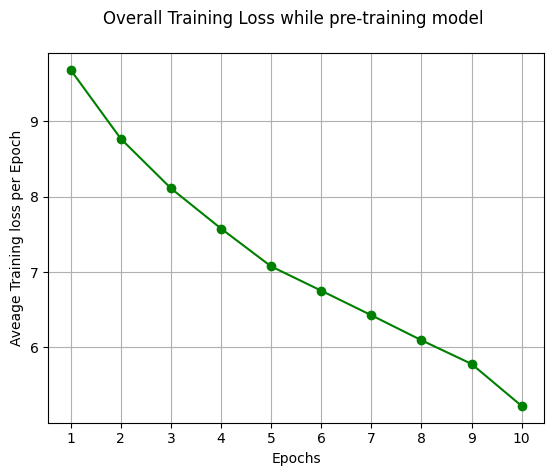

In [18]:
training_loss = Model_histroy.history['loss']

Epochs = range(1,11)

Training_loss = [training_loss[0],training_loss[1],training_loss[2],training_loss[3],training_loss[4],training_loss[5],training_loss[6],training_loss[7],training_loss[8],training_loss[9]]


# Create the plot
plt.plot(Epochs, Training_loss, marker='o',color='green')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Aveage Training loss per Epoch')
plt.title('Overall Training Loss while pre-training model \n')


# Display the plot
plt.grid(True)
plt.xticks(Epochs)
plt.show()


In [19]:
def check_accuracy1(X_test,Y_test,i):
  predictions = model.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

In [20]:
Final_test_accuracies=[]
for i in range(20):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy1(X_Test,Y_test,i)
  # Append each head accuracy into Test_accuracies list
  Final_test_accuracies.append(Temp_var)

29/29 [==============================] - 0s 5ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.8489130434782609
13/13 [==============================] - 0s 7ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.9725
10/10 [==============================] - 0s 9ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.9253246753246753
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C3: 0.7875
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.505
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.8642857142857143
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.7048710601719198
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C7: 

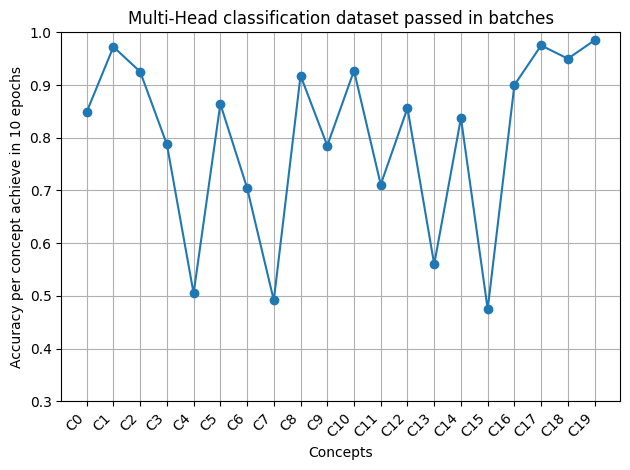

In [21]:
Concepts = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
                      'C15', 'C16', 'C17', 'C18', 'C19']

# Create the plot
plt.plot(Concepts, Final_test_accuracies, marker='o')

# Add labels and title
plt.xlabel('Concepts')
plt.ylabel('Accuracy per concept achieve in 10 epochs')
plt.title('Multi-Head classification dataset passed in batches')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.ylim(0.3, 1)
# Display the plot
plt.grid(True)
plt.tight_layout()  # To rotate the x-axis labels by 45 degrees.
plt.show()


In [22]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")

Layer 0: input_1
Layer 1: conv2d
Layer 2: batch_normalization
Layer 3: max_pooling2d
Layer 4: conv2d_1
Layer 5: batch_normalization_1
Layer 6: max_pooling2d_1
Layer 7: conv2d_2
Layer 8: batch_normalization_2
Layer 9: max_pooling2d_2
Layer 10: conv2d_3
Layer 11: batch_normalization_3
Layer 12: max_pooling2d_3
Layer 13: flatten
Layer 14: dense
Layer 15: dense_1
Layer 16: center_vs_notincenter
Layer 17: circle_vs_notcircle
Layer 18: Closed_vs_Open_figure
Layer 19: Colinear_vs_Noncolinear
Layer 20: Concave_vs_Convex
Layer 21: Four_vs_notfour_side
Layer 22: Triangle_vs_notTriangle
Layer 23: Clockwise_vs_Anticlock_wise
Layer 24: Left_vs_Right
Layer 25: Parallel_vs_perpendicular
Layer 26: Filled_vs_Unfilled
Layer 27: Complete_vs_Incomplete
Layer 28: Intersect_vs_NonIntersect
Layer 29: M_cluster_vs_N_clusters
Layer 30: Above_vs_Below
Layer 31: Same_vs_Not_Same
Layer 32: Size_big_vs_Small
Layer 33: Symmetery_vs_Non_symmetery
Layer 34: Horizontal_vs_Vertical
Layer 35: Empty_vs_Non_Empty


In [23]:
for layer in model.layers:
  layer.trainable = False
  print(layer.name)
  if layer.name == 'dense_1':
      break

input_1
conv2d
batch_normalization
max_pooling2d
conv2d_1
batch_normalization_1
max_pooling2d_1
conv2d_2
batch_normalization_2
max_pooling2d_2
conv2d_3
batch_normalization_3
max_pooling2d_3
flatten
dense
dense_1


In [24]:
from tensorflow.keras.initializers import glorot_uniform
predictions = Dense(1, activation='sigmoid',name='Bongard',kernel_initializer=glorot_uniform())(model.layers[-21].output) # -3 because by mistake already i did -18.
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy'
             )

# Created a function so that we can do cold-start each time for each bongard problem by reset the weights of bongard problem.
def reset_bongard_layer_weights():
    bongard_layer = model.get_layer('Bongard')
    bongard_layer.set_weights([glorot_uniform()(w.shape) for w in bongard_layer.get_weights()])

In [25]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")

Layer 0: input_1
Layer 1: conv2d
Layer 2: batch_normalization
Layer 3: max_pooling2d
Layer 4: conv2d_1
Layer 5: batch_normalization_1
Layer 6: max_pooling2d_1
Layer 7: conv2d_2
Layer 8: batch_normalization_2
Layer 9: max_pooling2d_2
Layer 10: conv2d_3
Layer 11: batch_normalization_3
Layer 12: max_pooling2d_3
Layer 13: flatten
Layer 14: dense
Layer 15: dense_1
Layer 16: Bongard


In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 47, 47, 32)       128 

In [27]:
def Bongard_data_load_split(Classifier_path):
    os.getcwd()
    dataset_path = os.getcwd()
    a = os.path.join('/content/Bongard Testing/BP_split',Classifier_path)
    A = os.path.join(dataset_path, a)
    A_A = os.path.join(A, '0')
    A_B = os.path.join(A, '1')
    A_A = glob.glob(A_A +"/*.png")
    A_B = glob.glob(A_B +"/*.png")
    A_A_arr =load_imgs(A_A)
    A_B_arr =load_imgs(A_B)


    # Generate labels corresponding to above concept classes.
    A_A_labels =  np.zeros([len(A_A_arr), 1], dtype = int)  #labeled as 0
    A_B_labels =  np.ones([len(A_B_arr), 1], dtype = int) #labeled as 1

    Ci_X = np.concatenate((A_A_arr, A_B_arr), axis=0)
    Ci_y = np.concatenate((A_A_labels , A_B_labels), axis=0)

    # Split the data into training and testing sets
    Ci_X_train, Ci_X_test, Ci_y_train, Ci_y_test = train_test_split(Ci_X, Ci_y,
                                                                    test_size=0.1, shuffle=True)

    return Ci_X_train,Ci_X_test,Ci_y_train,Ci_y_test

In [28]:
# # Path to the main folder
Bongard_dataset = "/content/Bongard Testing/BP_split"

# When achieve 100% accuracy in bongard problem.
hits=[]
# Append all accuracies received from bongard problem.
accuracy=[]
# Append all accuracies and loss from epoch 0 to 10 for all bongard problems.
training_loss_epoch_0=[]
training_accuracy_epoch_0=[]
training_loss_epoch_1=[]
training_accuracy_epoch_1=[]
training_loss_epoch_2=[]
training_accuracy_epoch_2=[]
training_loss_epoch_3=[]
training_accuracy_epoch_3=[]
training_loss_epoch_4=[]
training_accuracy_epoch_4=[]
training_loss_epoch_5=[]
training_accuracy_epoch_5=[]
training_loss_epoch_6=[]
training_accuracy_epoch_6=[]
training_loss_epoch_7=[]
training_accuracy_epoch_7=[]
training_loss_epoch_8=[]
training_accuracy_epoch_8=[]
training_loss_epoch_9=[]
training_accuracy_epoch_9=[]

subfolder_names = [name for name in os.listdir(Bongard_dataset) if os.path.isdir(os.path.join(Bongard_dataset, name))]
subfolder_names=sorted(subfolder_names)

for i, subfolder_name in enumerate(subfolder_names):

    # split the data by using function
    a,b,c,d=Bongard_data_load_split(subfolder_name)

    # Call the function to reset the weights of Bongard layer for cold start each time.
    reset_bongard_layer_weights()

    # Fit the training data (one bongard problem at a time)
    Model_history=model.fit(a, c, epochs=10)

    # Print real bongard Image:
#     print()
#     print("Bongard_image: ")
#     image_index = i #index to plot a image
#     plot_image_from_array(images_array, image_index)

#     print()
#     print("Training Images: ")
#     plot_images_with_labels(a,c)
#     print()


    for epoch in range(10):
      training_loss = Model_history.history['loss']
      training_accuracy = Model_history.history['accuracy']
      globals()[f'training_loss_epoch_{epoch}'].append(training_loss[epoch])
      globals()[f'training_accuracy_epoch_{epoch}'].append(training_accuracy[epoch])

    print("predicted labels : ",model.predict(b))
    predictions = model.predict(b)
    predictions_head = predictions
    threshold = 0.5
    binary_predictions_head = (predictions_head > threshold).astype(int)
    print("predicted binary labels : ",binary_predictions_head)
    accuracy_classifier = accuracy_score(d, binary_predictions_head)
    accuracy.append(accuracy_classifier)
    convert_int=int(accuracy_classifier)
    if convert_int==1:
        hits.append(convert_int)
    print(f'Accuracy for Bongard_problem{i}  :', accuracy_classifier)


#     print("original images with labels: ")
#     plot_images_with_labels(b,d)
#     print()

#     print("Predicted imaages with labels: ")
#     plot_images_with_labels(b,binary_predictions_head)
#     print()

Streaming output truncated to the last 5000 lines.
 [0.00185301]]
1/1 [==============================] - 0s 23ms/step
predicted binary labels :  [[0]
 [0]]
Accuracy for Bongard_problem205  : 0.5
Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.9353 - accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.9353 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 11ms/step - loss: 0.9346 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.9334 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.9316 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.9293 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.9266 - accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.9235 - accuracy: 0.5000
Epoch 9/10
1/1 [===================

In [29]:
print("Out of 391 bongard problems, model is able to solve ",len(hits), "problems correctly")

Out of 391 bongard problems, model is able to solve  103 problems correctly


In [30]:
print("Average bongard problem accuracy:",sum(accuracy)/391)

Average bongard problem accuracy: 0.4961636828644501


#### There are total 148 bongard problems out of 391 which belongs to 20 concepts, which I generated dataset to learn these 20 concepts.

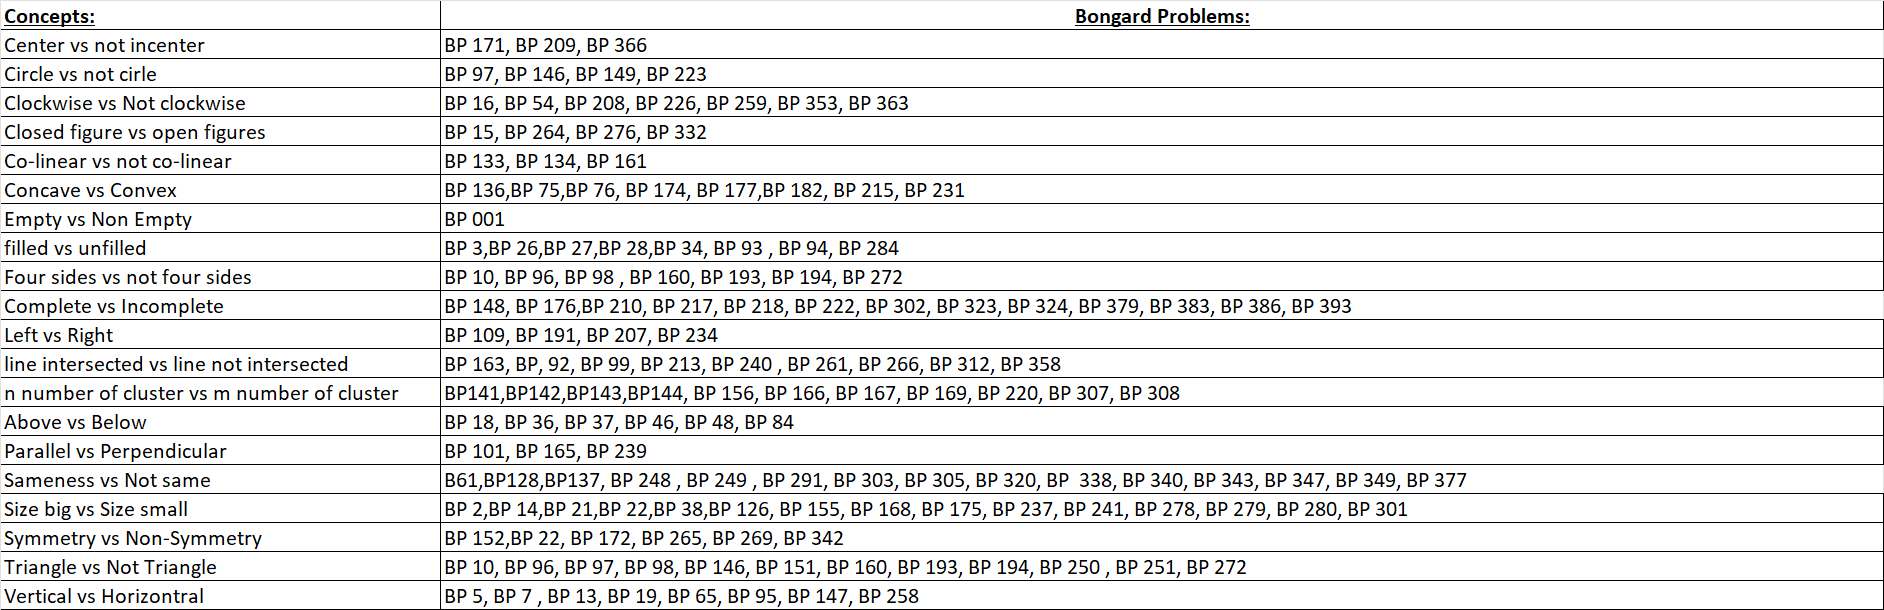

In [31]:
C0_Center_vs_not_incenter = sum([accuracy[170],accuracy[208],accuracy[365]]) / 3
C1_Circle_vs_not_cirle = sum([accuracy[96],accuracy[145],accuracy[148],accuracy[222]]) / 4
C2_Closed_figure_vs_open_figures = sum([accuracy[15],accuracy[53],accuracy[170]] ) / 3
C3_Colinear_vs_not_colinear = sum( [accuracy[132],accuracy[133],accuracy[160]] ) / 3
C4_Concave_vs_Convex = sum([accuracy[135],accuracy[74],accuracy[75],accuracy[173],accuracy[176],accuracy[181],accuracy[214],accuracy[230]]) / 9
C5_Four_sides_vs_not_four_sides = sum([accuracy[9],accuracy[95],accuracy[97],accuracy[159],accuracy[192],accuracy[193],accuracy[271]]) / 7
C6_Triangle_vs_Not_Triangle = sum([accuracy[9],accuracy[95],accuracy[96],accuracy[97],accuracy[145],accuracy[150],accuracy[159],accuracy[192],accuracy[193],accuracy[249],accuracy[250],accuracy[271]])/12
C7_Clockwise_vs_Not_clockwise = sum([accuracy[15],accuracy[53],accuracy[207],accuracy[225],accuracy[258],accuracy[352],accuracy[362]]) / 7
C8_Left_vs_Right = sum([accuracy[108],accuracy[190],accuracy[206],accuracy[233]]) / 4
C9_Parallel_vs_Perpendicular = sum([accuracy[100],accuracy[164],accuracy[238]]) / 3
C10_filled_vs_unfilled = sum([accuracy[2],accuracy[25],accuracy[26],accuracy[27],accuracy[33],accuracy[92],accuracy[93],accuracy[283]])/8
C11_Complete_vs_Incomplete = sum([accuracy[147],accuracy[175],accuracy[209],accuracy[216],accuracy[217],accuracy[221],accuracy[301],accuracy[321],accuracy[323]
                                  ,accuracy[378],accuracy[382],accuracy[385],accuracy[389]]) / 13
C12_line_intersected_vs_line_not_intersected = sum([accuracy[162],accuracy[91],accuracy[98],accuracy[212],accuracy[239],accuracy[260],accuracy[265],accuracy[311],accuracy[357]]) / 9
C13_n_number_of_cluster_vs_m_number_of_cluster = sum([accuracy[140],accuracy[141],accuracy[142],accuracy[143],accuracy[155],accuracy[165],accuracy[166],accuracy[168],accuracy[219],
                                                      accuracy[306],accuracy[307]]) / 11
C14_Above_vs_Below = sum([accuracy[17],accuracy[35],accuracy[36],accuracy[45],accuracy[47],accuracy[83]])  / 6
C15_Sameness_vs_Not_same = sum([accuracy[60],accuracy[127],accuracy[136],accuracy[247],accuracy[248],accuracy[290],accuracy[302],accuracy[304],accuracy[319],accuracy[337],accuracy[339],
                                accuracy[342],accuracy[346],accuracy[348],accuracy[376]]) / 15
C16_Size_big_vs_Size_small = sum([accuracy[1],accuracy[13],accuracy[20],accuracy[21],accuracy[37],accuracy[125],accuracy[154],accuracy[167],accuracy[174],accuracy[236],accuracy[240],
                                  accuracy[277],accuracy[278],accuracy[279],accuracy[300]]) / 15
C17_Symmetry_vs_NonSymmetry = sum([accuracy[151],accuracy[21],accuracy[171],accuracy[264],accuracy[268],accuracy[341]]) / 6
C18_Vertical_vs_Horizontral = sum([accuracy[4],accuracy[6],accuracy[12],accuracy[18],accuracy[64],accuracy[94],accuracy[146],accuracy[257]]) / 8
C19_Empty_vs_Non_Empty = accuracy[0]

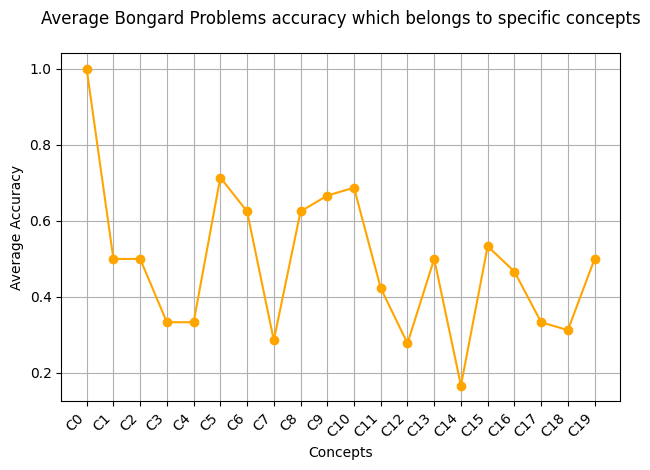

In [39]:
BP_belong_to_Concepts_avg_accuracy=[C0_Center_vs_not_incenter,C1_Circle_vs_not_cirle,C2_Closed_figure_vs_open_figures,C3_Colinear_vs_not_colinear,C4_Concave_vs_Convex,
                                    C5_Four_sides_vs_not_four_sides,C6_Triangle_vs_Not_Triangle,C7_Clockwise_vs_Not_clockwise,C8_Left_vs_Right,C9_Parallel_vs_Perpendicular,
                                    C10_filled_vs_unfilled,C11_Complete_vs_Incomplete,C12_line_intersected_vs_line_not_intersected,C13_n_number_of_cluster_vs_m_number_of_cluster,
                                    C14_Above_vs_Below,C15_Sameness_vs_Not_same,C16_Size_big_vs_Size_small,C17_Symmetry_vs_NonSymmetry,C18_Vertical_vs_Horizontral,C19_Empty_vs_Non_Empty]

Concepts = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
                      'C15', 'C16', 'C17', 'C18', 'C19']

# Create the plot
plt.plot(Concepts, BP_belong_to_Concepts_avg_accuracy, marker='o',color='orange')

# Add labels and title
plt.xlabel('Concepts')
plt.ylabel('Average Accuracy')
plt.title('Average Bongard Problems accuracy which belongs to specific concepts\n')

# Display the plot
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()  # To rotate the x-axis labels by 45 degrees.
plt.show()

In [33]:
BP_belong_to_Concepts_avg_accuracy

[1.0,
 0.5,
 0.5,
 0.3333333333333333,
 0.3333333333333333,
 0.7142857142857143,
 0.625,
 0.2857142857142857,
 0.625,
 0.6666666666666666,
 0.6875,
 0.4230769230769231,
 0.2777777777777778,
 0.5,
 0.16666666666666666,
 0.5333333333333333,
 0.4666666666666667,
 0.3333333333333333,
 0.3125,
 0.5]

In [ ]:
sum(BP_belong_to_Concepts_avg_accuracy) # 0.48

In [34]:
training_loss_epoch_0_avg=sum(training_loss_epoch_0)/len(training_loss_epoch_0)
training_accuracy_epoch_0_avg=sum(training_accuracy_epoch_0)/len(training_accuracy_epoch_0)
training_loss_epoch_1_avg=sum(training_loss_epoch_1)/len(training_loss_epoch_1)
training_accuracy_epoch_1_avg=sum(training_accuracy_epoch_1)/len(training_accuracy_epoch_1)
training_loss_epoch_2_avg=sum(training_loss_epoch_2)/len(training_loss_epoch_2)
training_accuracy_epoch_2_avg=sum(training_accuracy_epoch_2)/len(training_accuracy_epoch_2)
training_loss_epoch_3_avg=sum(training_loss_epoch_3)/len(training_loss_epoch_3)
training_accuracy_epoch_3_avg=sum(training_accuracy_epoch_3)/len(training_accuracy_epoch_3)
training_loss_epoch_4_avg=sum(training_loss_epoch_4)/len(training_loss_epoch_4)
training_accuracy_epoch_4_avg=sum(training_accuracy_epoch_4)/len(training_accuracy_epoch_4)
training_loss_epoch_5_avg=sum(training_loss_epoch_5)/len(training_loss_epoch_5)
training_accuracy_epoch_5_avg=sum(training_accuracy_epoch_5)/len(training_accuracy_epoch_5)
training_loss_epoch_6_avg=sum(training_loss_epoch_6)/len(training_loss_epoch_6)
training_accuracy_epoch_6_avg=sum(training_accuracy_epoch_6)/len(training_accuracy_epoch_6)
training_loss_epoch_7_avg=sum(training_loss_epoch_7)/len(training_loss_epoch_7)
training_accuracy_epoch_7_avg=sum(training_accuracy_epoch_7)/len(training_accuracy_epoch_7)
training_loss_epoch_8_avg=sum(training_loss_epoch_8)/len(training_loss_epoch_8)
training_accuracy_epoch_8_avg=sum(training_accuracy_epoch_8)/len(training_accuracy_epoch_8)
training_loss_epoch_9_avg=sum(training_loss_epoch_9)/len(training_loss_epoch_9)
training_accuracy_epoch_9_avg=sum(training_accuracy_epoch_9)/len(training_accuracy_epoch_9)

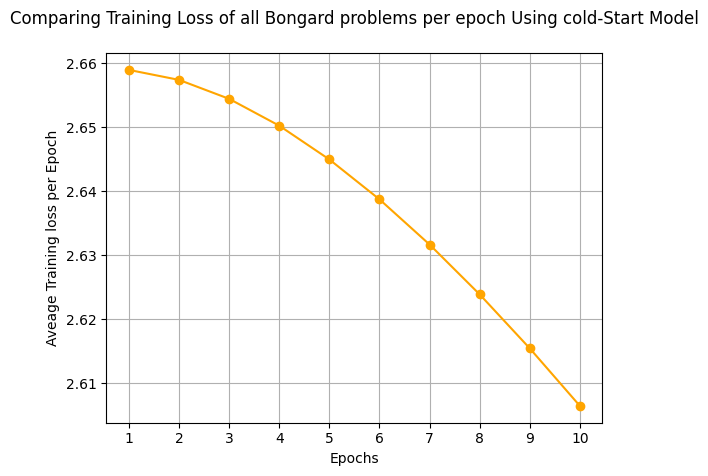

In [35]:
Epochs = range(1,11)

Training_loss=[training_loss_epoch_0_avg,training_loss_epoch_1_avg,training_loss_epoch_2_avg,training_loss_epoch_3_avg,training_loss_epoch_4_avg,training_loss_epoch_5_avg,training_loss_epoch_6_avg,
               training_loss_epoch_7_avg,training_loss_epoch_8_avg,training_loss_epoch_9_avg]

# Training_accuracies=[training_accuracy_epoch_0_avg,training_accuracy_epoch_1_avg,training_accuracy_epoch_2_avg,training_accuracy_epoch_3_avg,training_accuracy_epoch_4_avg,training_accuracy_epoch_5_avg,
#                      training_accuracy_epoch_6_avg,training_accuracy_epoch_7_avg,training_accuracy_epoch_8_avg,training_accuracy_epoch_9_avg]

# Create the plot
plt.plot(Epochs, Training_loss, marker='o',color='orange')
# plt.plot(Epochs, Training_accuracies, marker='o',color='green')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Aveage Training loss per Epoch')
plt.title('Comparing Training Loss of all Bongard problems per epoch Using cold-Start Model\n')

# Display the plot
plt.grid(True)
plt.xticks(Epochs)
plt.show()

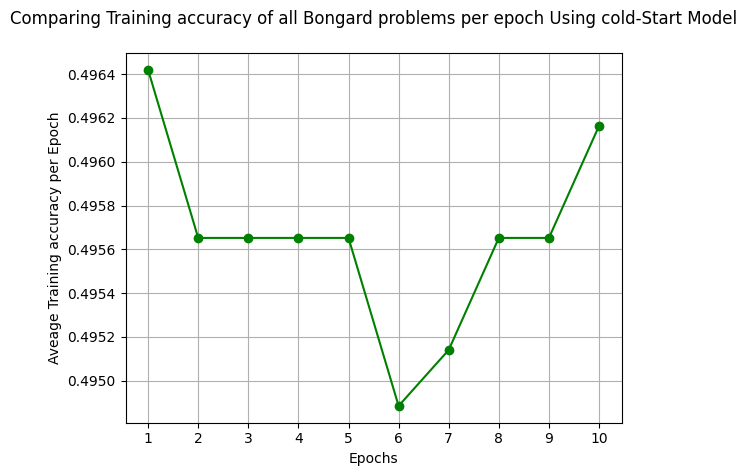

In [36]:
Epochs = range(1,11)

# Training_loss=[training_loss_epoch_0_avg,training_loss_epoch_1_avg,training_loss_epoch_2_avg,training_loss_epoch_3_avg,training_loss_epoch_4_avg,training_loss_epoch_5_avg,training_loss_epoch_6_avg,
#                training_loss_epoch_7_avg,training_loss_epoch_8_avg,training_loss_epoch_9_avg]

Training_accuracies=[training_accuracy_epoch_0_avg,training_accuracy_epoch_1_avg,training_accuracy_epoch_2_avg,training_accuracy_epoch_3_avg,training_accuracy_epoch_4_avg,training_accuracy_epoch_5_avg,
                     training_accuracy_epoch_6_avg,training_accuracy_epoch_7_avg,training_accuracy_epoch_8_avg,training_accuracy_epoch_9_avg]

# Create the plot
# plt.plot(Epochs, Training_loss, marker='o',color='orange')
plt.plot(Epochs, Training_accuracies, marker='o',color='green')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Aveage Training accuracy per Epoch')
plt.title('Comparing Training accuracy of all Bongard problems per epoch Using cold-Start Model\n')

# Display the plot
plt.grid(True)
plt.xticks(Epochs)
plt.show()

In [37]:
end_time = time.time()
epoch_time = end_time - start_time
print()
print("Total Time to be taked:", epoch_time, "seconds")


Total Time to be taked: 600.6694798469543 seconds
